In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as style
from mplfinance import candlestick2_ochl
import matplotlib.dates as mdates
import plotly.graph_objs as go
import seaborn as sns
sns.set_style("darkgrid")
from ta.momentum import RSIIndicator
from ta.trend import MACD
from datetime import datetime, timedelta


In [2]:
df = pd.read_csv("Official_Dataset.csv")

In [3]:
tickers = list(df["Ticker"].unique())
# print(tickers)

In [4]:

def stockSetup(df, ticker):
    '''the stock setup function cleans the dataframe and filters it according to a specific ticker you input'''
    if ticker in tickers:
        stockData = df[df["Ticker"]==ticker]
    else:
        raise Exception("Ticker is not valid")
  
    stockData = stockData.drop('Ticker', axis=1)
    stockData = stockData.drop("File", axis=1)
    stockData = stockData.round(2)
    stockData['Date'] = pd.to_datetime(stockData['Date'])
    stockData.dropna(axis=0, inplace=True)
    stockData = stockData.set_index('Date')
    return stockData


# these functions below convert the object oriented version of the TA library into functions that are easy to call
def generateRSI(df, period=14):
  return RSIIndicator(df["Adj Close"], period).rsi()

def generateMACD(df, periodShort=12, periodLong=26):
  return MACD(df["Adj Close"], n_slow=periodShort, n_fast=periodLong).macd()

def generateMACDSignal(df, period=9):
  return MACD(df["Adj Close"], n_sign=period).macd_signal()

def generateMACDDiff(df, periodShort=12, periodLong=26, periodSign=9):
  return MACD(df["Adj Close"], n_slow=periodShort, n_fast=periodLong, n_sign=periodSign).macd_diff()

def generatePercentageChange(df):
  return df["Adj Close"].pct_change()*100

In [12]:
figures = []
def plotAdjClose(df):
  figures.append(plt.figure(figsize=(15,8)))
  sns.lineplot(x = df.index, y=df['Adj Close'])
  plt.show()

def plotRSI(df, overBought=70, overSold=30, period=14):
  df["RSI"] = generateRSI(df, period)
  figures.append(plt.figure(figsize=(15,3)))
  sns.lineplot(x = df.index, y=df['RSI'])
  plt.plot([df.index.min(),df.index.max()],[overBought, overBought])
  plt.plot([df.index.min(),df.index.max()],[overSold, overSold])
  plt.show()

def plotMACD(df, periodShort=12, periodLong=26, periodSignal=9):
  df['MACD'] = generateMACD(df, periodShort, periodLong)
  df["MACD Signal"] = generateMACDSignal(df, periodSignal)
  df['MACD Difference'] = generateMACDDiff(df, periodShort, periodLong, periodSignal)
  figures.append(plt.figure(figsize=(15,3)))
  sns.lineplot(x = df.index, y=df['MACD'])
  sns.lineplot(x = df.index, y=df['MACD Signal'])
  plt.show()

def plotPercentageChange(df):
  df['Percentage Change'] = generatePercentageChange(df)
  figures.append(plt.figure(figsize=(15,3)))
  sns.lineplot(x = df.index, y=df['Percentage Change'])
  plt.show()

def plotVolume(df):
  figures.append(plt.figure(figsize=(15,3)))
  sns.lineplot(x=df.index, y=df['Volume'])



In [6]:
generatedData = stockSetup(df, "AAPL")
generatedData.head(-5)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2005-01-03,3.92,4.52,4.65,4.47,4.63,172998000.0
2005-01-04,3.96,4.57,4.68,4.50,4.56,274202600.0
2005-01-05,4.00,4.61,4.66,4.57,4.60,170108400.0
2005-01-06,4.00,4.61,4.64,4.52,4.62,176388800.0
2005-01-07,4.29,4.95,4.97,4.62,4.64,556862600.0
...,...,...,...,...,...,...
2019-12-17,279.75,280.41,281.77,278.80,279.57,28539600.0
2019-12-18,279.08,279.74,281.90,279.12,279.80,29007100.0
2019-12-19,279.36,280.02,281.18,278.95,279.50,24592300.0


In [7]:
#years = generatedData.index.year.unique() # Change this to be specific years you want to filter out
years = [2019]
filteredDf = generatedData[generatedData.index.year.isin(years)]

months = filteredDf.index.month.unique() # Change this to be specific months you want to filter out
#months = [#put your months here]
filteredDf = filteredDf[filteredDf.index.month.isin(months)]

days = filteredDf.index.day.unique() # Change this to be specific days you want to filter out
#days = [#put your days here]
filteredDf = filteredDf[filteredDf.index.day.isin(days)]



In [29]:
def createCandlestck(df): 
    data=[go.Candlestick(x=filteredDf.index,
                open=filteredDf['Open'],
                high=filteredDf['High'],
                low=filteredDf['Low'],
                close=filteredDf['Close'])]
    return go.Figure(data=data)

createCandlestck(df).show()

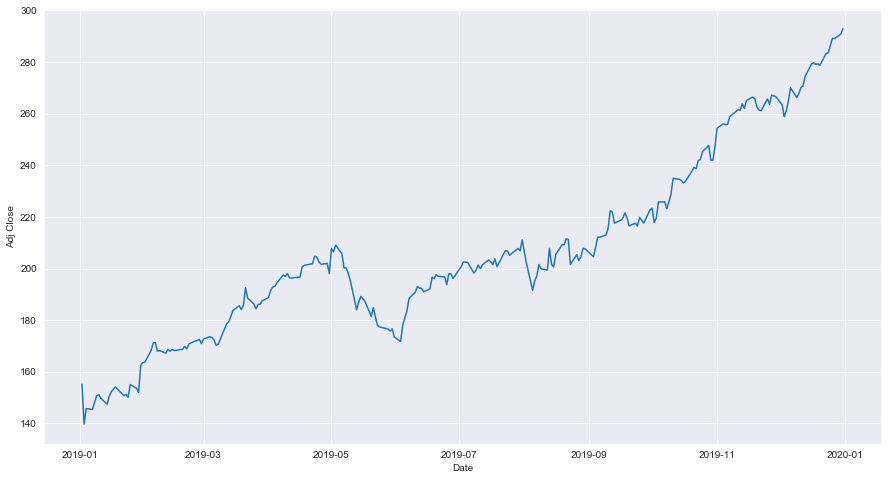

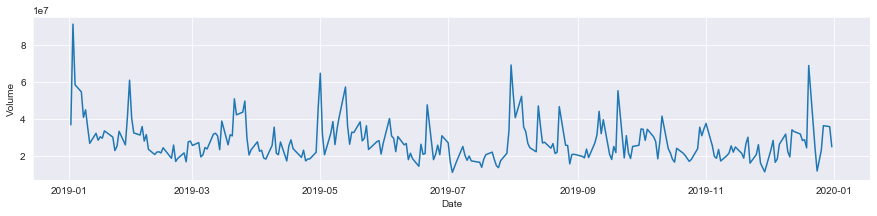

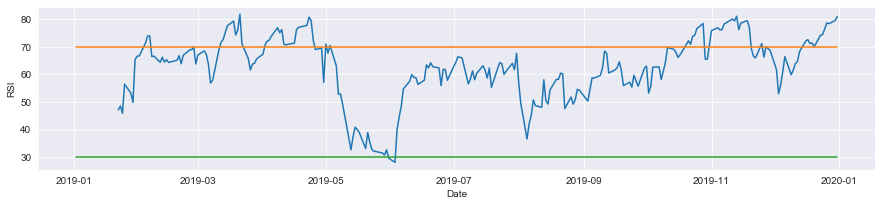

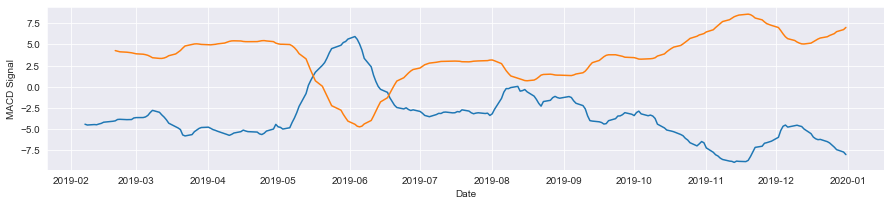

In [8]:
plotAdjClose(filteredDf)
plotVolume(filteredDf)
#plotPercentageChange(filteredDf)
plotRSI(filteredDf, overBought=70, overSold=30)
plotMACD(filteredDf)


In [19]:

SmaWindow=7
newDf = stockSetup(df, 'AAPL')
newDf["RSI"] = generateRSI(newDf)
newDf["MACD"] = generateMACD(newDf)
newDf["SMA"] = newDf['Adj Close'].rolling(window=SmaWindow).mean()

#plt.figure(figsize=(15,8))
#sns.lineplot(x = df.index, y=df['Adj Close'])
#sns.lineplot(x = df.index, y=df["SMA"])
# plt.show()

fallingKniveDf = newDf[newDf["MACD"] <= -.5]
fallingKniveDf = newDf[newDf['Adj Close'] < newDf['SMA']]
fallingKniveDf = newDf[newDf['RSI'] <40]

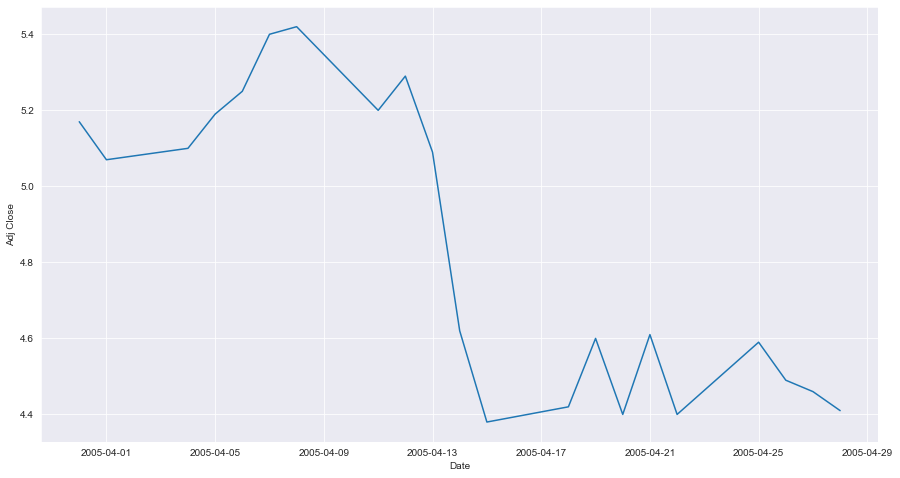

In [23]:
# takes the filtered df from cell above and graphs a specific interval around that date
aroundIndex = []
for date in fallingKniveDf.index:
    aroundIndex.append(pd.date_range(start=date - timedelta(weeks=2), end=date+ timedelta(weeks=2)))

FallingKnifeSubset = []
for dates in aroundIndex:
    FallingKnifeSubset.append(newDf[newDf.index.isin(dates)])

plotAdjClose(FallingKnifeSubset[0])